In [1]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Layer, Dense, Conv2D, MaxPooling2D, Input, Flatten
from keras.metrics import Precision, Recall
from matplotlib import pyplot as plt
import numpy as np
import uuid
import os
import cv2

2023-04-25 16:59:39.373376: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ANC_PATH = os.path.join("data", "anchor", "*.jpg")
POS_PATH = os.path.join("data", "positive", "*.jpg")
NEG_PATH = os.path.join("data", "negative", "*.jpg")

In [3]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    
    ret, frame = cap.read()
    
    frame = frame[200:200+250, 580:580+250, :]
    
    cv2.imshow("Webcam:", frame)
    
    if cv2.waitKey(1) & 0xFF == ord("a"):
        imgname = os.path.join("data", "anchor", "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    if cv2.waitKey(1) & 0XFF == ord("p"):
        imgname = os.path.join("data", "positive", "{}.jpg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

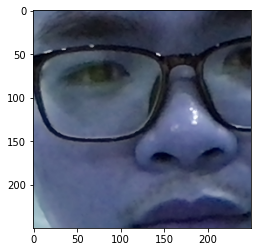

In [14]:
plt.imshow(frame)

In [5]:
frame.shape

(250, 250, 3)

In [11]:
frame[200:200+250, 600:600+250, :].shape

(250, 250, 3)

In [7]:
frame

array([[[107, 128, 154],
        [106, 127, 153],
        [106, 126, 154],
        ...,
        [ 25,  27,  33],
        [ 26,  28,  34],
        [ 25,  27,  33]],

       [[108, 129, 155],
        [107, 128, 154],
        [107, 127, 155],
        ...,
        [ 27,  29,  35],
        [ 27,  29,  36],
        [ 25,  27,  33]],

       [[110, 130, 156],
        [108, 129, 156],
        [107, 127, 155],
        ...,
        [ 26,  28,  34],
        [ 26,  28,  34],
        [ 25,  27,  33]],

       ...,

       [[155, 187, 195],
        [157, 188, 196],
        [157, 188, 196],
        ...,
        [ 51,  63,  89],
        [ 52,  64,  90],
        [ 53,  65,  91]],

       [[157, 188, 196],
        [157, 188, 196],
        [157, 188, 196],
        ...,
        [ 53,  66,  93],
        [ 54,  68,  94],
        [ 55,  69,  95]],

       [[158, 189, 198],
        [157, 188, 197],
        [157, 188, 196],
        ...,
        [ 56,  69,  97],
        [ 57,  71,  99],
        [ 58,  72, 100]]

In [88]:
def data_augmentation(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1, 2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1, 3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100), np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9, upper=1, seed=(np.random.randint(100), np.random.randint(100)))
        
        data.append(img)
        
    return data      

In [109]:
for file_name in os.listdir("data/positive"):
    image_path = os.path.join("data/positive", file_name)
    img = cv2.imread(image_path)
    aug_images = data_augmentation(img)

    for image in aug_images:
        cv2.imwrite(os.path.join("data/positive", "{}.jpg".format(uuid.uuid1())), image.numpy())

In [3]:
anchor = tf.data.Dataset.list_files(ANC_PATH).take(2000)
positive = tf.data.Dataset.list_files(POS_PATH).take(2000)
negative = tf.data.Dataset.list_files(NEG_PATH).take(2000)

2023-04-25 16:59:53.161204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
negative.as_numpy_iterator().next()

b'data/negative/Stefano_Accorsi_0002.jpg'

In [4]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105, 105))
    img = img / 255.0
    
    return img

In [6]:
preprocess(b'data/negative/Christian_Von_Wernich_0001.jpg')

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.98944914, 0.9972923 , 0.9933707 ],
        [0.98944914, 0.9972923 , 0.9933707 ],
        [0.98944914, 0.9972923 , 0.9933707 ],
        ...,
        [0.97432303, 0.97040147, 0.8880485 ],
        [0.9611511 , 0.95722955, 0.8748766 ],
        [0.9502334 , 0.94631183, 0.8639589 ]],

       [[0.9843137 , 1.        , 0.99607843],
        [0.9848339 , 1.        , 0.99607843],
        [0.99159664, 1.        , 0.99607843],
        ...,
        [0.97040147, 0.97040147, 0.8721756 ],
        [0.957423  , 0.957423  , 0.8621849 ],
        [0.95686275, 0.95686275, 0.85975724]],

       [[0.97861814, 0.99785244, 0.99215686],
        [0.9787448 , 0.9977258 , 0.99215686],
        [0.98039216, 0.99607843, 0.99215686],
        ...,
        [0.96862745, 0.96862745, 0.86237156],
        [0.96271175, 0.96271175, 0.8564559 ],
        [0.9647059 , 0.9647059 , 0.85845   ]],

       ...,

       [[0.22458985, 0.1814526 , 0.24811926],
        [0.21

In [7]:
img = preprocess(b'data/negative/Christian_Von_Wernich_0001.jpg')

In [8]:
img.numpy().min()

0.05732757

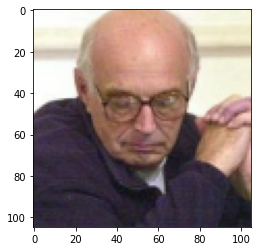

In [9]:
plt.imshow(img)

In [5]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [6]:
data.as_numpy_iterator().next()

(b'data/anchor/449cc054-ca14-11ed-a5d0-acde48001122.jpg',
 b'data/positive/9b0fd282-ca14-11ed-a5d0-acde48001122.jpg',
 1.0)

In [12]:
ex = data.as_numpy_iterator().next()

In [6]:
def preprocess_twin(input_img, validation_img, label):
    
    return (preprocess(input_img), preprocess(validation_img), label)

In [14]:
res = preprocess_twin(*ex)

In [15]:
res[2]

1.0

In [7]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 5500)

train_data = data.take(round(len(data) * .7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

test_data = data.skip(round(len(data) * .7))
test_data = test_data.take(round(len(data) * .3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [8]:
def make_embedding():
    
    inp = Input(shape = (105, 105, 3), name = "input_image")
    
    c1 = Conv2D(64, (10, 10), activation = "relu")(inp)
    m1 = MaxPooling2D(64, (2, 2), padding = "same")(c1)
    
    c2 = Conv2D(128, (7, 7), activation = "relu")(m1)
    m2 = MaxPooling2D(64, (2, 2), padding = "same")(c2)
    
    c3 = Conv2D(128, (4, 4), activation = "relu")(m2)
    m3 = MaxPooling2D(64, (2, 2), padding = "same")(c3)
    
    c4 = Conv2D(256, (4, 4), activation = "relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = "sigmoid")(f1)
    
    return Model(inputs = [inp], outputs = [d1], name = "embedding")

embedding = make_embedding()

In [9]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [9]:
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [10]:
def make_siamese_model():
    
    input_image = Input(name = "input_image", shape = (105, 105, 3))
    
    validation_image = Input(name = "val_image", shape = (105, 105, 3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = "distance"
    
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation = "sigmoid")(distances)
    
    return Model(inputs = [input_image, validation_image], outputs = [classifier], name = "siameseNetwork")

siamese_model = make_siamese_model()

In [12]:
siamese_model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 val_image (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'val_image[0][0]'] 

In [16]:
siamese_model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                      optimizer = tf.keras.optimizers.Adam(1e-4),
                      metrics = ["accuracy"])

In [13]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [14]:
checkpoint_prefix = os.path.join("training_checkpoints", "ckpt")
checkpoint = tf.train.Checkpoint( opt = opt, siamese_model = siamese_model)

In [11]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        x = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(x, training = True)
        loss = binary_cross_loss(y, yhat)
    
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [12]:
def train(data, EPOCHS):
    
    for epoch in range(1, EPOCHS + 1):
        print("\n Epoch {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            y_hat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], y_hat)
            p.update_state(batch[2], y_hat)
            progbar.update(idx + 1)
            
        print(f"Loss:{loss.numpy()} | Recall:{r.result().numpy()} | Precision:{p.result().numpy()}")
            
        if epoch % 10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [24]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
175/175 [==============================] - 2735s 16s/step
Loss:0.07927955687046051 | Recall:0.9363057613372803 | Precision:0.9792746305465698

 Epoch 2/50
1/1 [==============================] - 1s 1s/step:


175/175 [==============================] - 2010s 11s/step
Loss:0.006662661209702492 | Recall:0.9423897862434387 | Precision:0.9917664527893066

 Epoch 3/50
175/175 [==============================] - 30534s 175s/step
Loss:0.08947218954563141 | Recall:0.9599714279174805 | Precision:0.9896831512451172

 Epoch 4/50
1/1 [==============================] - 2s 2s/step4:


175/175 [==============================] - 1813s 10s/step
Loss:0.12805545330047607 | Recall:0.9635193347930908 | Precision:0.9926307797431946

 Epoch 5/50
175/175 [==============================] - 1815s 10s/step
Loss:0.009889477863907814 | Recall:0.9839298725128174 | Precision:0.9955654144287109

 Epoch 6/50
1/1 [==============================] - 1s 1s/step1:


175/175 [==============================] - 1803s 10s/step
Loss:0.16204504668712616 | Recall:0.9850533604621887 | Precision:0.9935390949249268

 Epoch 7/50
175/175 [==============================] - 1806s 10s/step
Loss:0.0009614127920940518 | Recall:0.9893918037414551 | Precision:0.9971489906311035

 Epoch 8/50
1/1 [==============================] - 2s 2s/step7:


175/175 [==============================] - 1804s 10s/step
Loss:0.002992094960063696 | Recall:0.9942113161087036 | Precision:0.9985465407371521

 Epoch 9/50
1/1 [==============================] - 2s 2s/step:


175/175 [==============================] - 1807s 10s/step
Loss:0.12227466702461243 | Recall:0.9935158491134644 | Precision:0.9956678748130798

 Epoch 10/50
175/175 [==============================] - 1815s 10s/step
Loss:0.00044010195415467024 | Recall:0.9957112073898315 | Precision:0.9978510141372681

 Epoch 11/50
1/1 [==============================] - 1s 1s/step1:


175/175 [==============================] - 1797s 10s/step
Loss:0.008907089941203594 | Recall:0.9985496997833252 | Precision:0.9992743134498596

 Epoch 12/50
175/175 [==============================] - 1790s 10s/step
Loss:0.023106377571821213 | Recall:0.9778096079826355 | Precision:0.9884225726127625

 Epoch 13/50
1/1 [==============================] - 2s 2s/step7:


175/175 [==============================] - 1807s 10s/step
Loss:0.0004941340303048491 | Recall:0.9950669407844543 | Precision:1.0

 Epoch 14/50
175/175 [==============================] - 1793s 10s/step
Loss:0.29553085565567017 | Recall:0.9929726123809814 | Precision:0.9964739084243774

 Epoch 15/50
1/1 [==============================] - 1s 1s/step4:


175/175 [==============================] - 1805s 10s/step
Loss:0.03991056606173515 | Recall:0.9860140085220337 | Precision:0.9839497804641724

 Epoch 16/50
1/1 [==============================] - 2s 2s/step:


175/175 [==============================] - 1804s 10s/step
Loss:0.009209845215082169 | Recall:0.9942979216575623 | Precision:0.9957173466682434

 Epoch 17/50
175/175 [==============================] - 1804s 10s/step
Loss:0.02011224627494812 | Recall:0.9985693693161011 | Precision:0.9992842078208923

 Epoch 18/50
1/1 [==============================] - 2s 2s/step:


175/175 [==============================] - 1793s 10s/step
Loss:0.007142113987356424 | Recall:1.0 | Precision:1.0

 Epoch 19/50
175/175 [==============================] - 1793s 10s/step
Loss:0.015645518898963928 | Recall:1.0 | Precision:1.0

 Epoch 20/50
1/1 [==============================] - 2s 2s/step4:


175/175 [==============================] - 1799s 10s/step
Loss:0.004667170811444521 | Recall:1.0 | Precision:1.0

 Epoch 21/50
175/175 [==============================] - 1787s 10s/step
Loss:0.002981244120746851 | Recall:1.0 | Precision:1.0

 Epoch 22/50
1/1 [==============================] - 2s 2s/step0:


175/175 [==============================] - 1785s 10s/step
Loss:0.0007309893844649196 | Recall:1.0 | Precision:1.0

 Epoch 23/50
175/175 [==============================] - 1799s 10s/step
Loss:9.797650818654802e-06 | Recall:1.0 | Precision:1.0

 Epoch 24/50
1/1 [==============================] - 2s 2s/step7:


175/175 [==============================] - 1808s 10s/step
Loss:0.0008571863290853798 | Recall:1.0 | Precision:1.0

 Epoch 25/50
1/1 [==============================] - 2s 2s/step:


175/175 [==============================] - 1819s 10s/step
Loss:4.914687815471552e-05 | Recall:1.0 | Precision:1.0

 Epoch 26/50
175/175 [==============================] - 1815s 10s/step
Loss:0.0003446466289460659 | Recall:1.0 | Precision:1.0

 Epoch 27/50
1/1 [==============================] - 2s 2s/step0:


175/175 [==============================] - 1809s 10s/step
Loss:3.9924245356814936e-05 | Recall:1.0 | Precision:1.0

 Epoch 28/50
175/175 [==============================] - 1812s 10s/step
Loss:1.7536312952870503e-05 | Recall:1.0 | Precision:1.0

 Epoch 29/50
1/1 [==============================] - 2s 2s/step7:


175/175 [==============================] - 1813s 10s/step
Loss:0.0006330983014777303 | Recall:1.0 | Precision:1.0

 Epoch 30/50
175/175 [==============================] - 1802s 10s/step
Loss:1.526305277366191e-05 | Recall:1.0 | Precision:1.0

 Epoch 31/50
1/1 [==============================] - 2s 2s/step3:


175/175 [==============================] - 1809s 10s/step
Loss:1.1895136594830547e-05 | Recall:1.0 | Precision:1.0

 Epoch 32/50
175/175 [==============================] - 1806s 10s/step
Loss:0.00013270109775476158 | Recall:1.0 | Precision:1.0

 Epoch 33/50


175/175 [==============================] - 1801s 10s/step
Loss:2.332048552489141e-06 | Recall:1.0 | Precision:1.0

 Epoch 34/50
1/1 [==============================] - 1s 1s/step:


175/175 [==============================] - 1802s 10s/step
Loss:5.169484575162642e-05 | Recall:1.0 | Precision:1.0

 Epoch 35/50
175/175 [==============================] - 1798s 10s/step
Loss:4.805675871466519e-06 | Recall:1.0 | Precision:1.0

 Epoch 36/50
1/1 [==============================] - 2s 2s/step3:


175/175 [==============================] - 1798s 10s/step
Loss:2.376749534960254e-06 | Recall:1.0 | Precision:1.0

 Epoch 37/50
175/175 [==============================] - 1791s 10s/step
Loss:1.2934911865158938e-05 | Recall:1.0 | Precision:1.0

 Epoch 38/50
1/1 [==============================] - 2s 2s/step9:


175/175 [==============================] - 1797s 10s/step
Loss:1.073700150300283e-05 | Recall:1.0 | Precision:1.0

 Epoch 39/50
175/175 [==============================] - 1800s 10s/step
Loss:6.9515886025328655e-06 | Recall:1.0 | Precision:1.0

 Epoch 40/50
1/1 [==============================] - 2s 2s/step6:


175/175 [==============================] - 1790s 10s/step
Loss:5.666283414029749e-06 | Recall:1.0 | Precision:1.0

 Epoch 41/50
1/1 [==============================] - 2s 2s/step:


175/175 [==============================] - 1804s 10s/step
Loss:3.337128146085888e-05 | Recall:1.0 | Precision:1.0

 Epoch 42/50
175/175 [==============================] - 1793s 10s/step
Loss:4.328260547481477e-05 | Recall:1.0 | Precision:1.0

 Epoch 43/50
1/1 [==============================] - 2s 2s/step:


175/175 [==============================] - 1799s 10s/step
Loss:1.2886662261735182e-05 | Recall:1.0 | Precision:1.0

 Epoch 44/50
175/175 [==============================] - 1805s 10s/step
Loss:2.851990757335443e-05 | Recall:1.0 | Precision:1.0

 Epoch 45/50
1/1 [==============================] - 2s 2s/step5:


175/175 [==============================] - 1797s 10s/step
Loss:1.6838371266203467e-06 | Recall:1.0 | Precision:1.0

 Epoch 46/50
175/175 [==============================] - 1794s 10s/step
Loss:7.331786036957055e-05 | Recall:1.0 | Precision:1.0

 Epoch 47/50
1/1 [==============================] - 2s 2s/step2:


175/175 [==============================] - 1801s 10s/step
Loss:8.840217560646124e-06 | Recall:1.0 | Precision:1.0

 Epoch 48/50
175/175 [==============================] - 1802s 10s/step
Loss:4.470409294299316e-06 | Recall:1.0 | Precision:1.0

 Epoch 49/50
1/1 [==============================] - 2s 2s/step8:


175/175 [==============================] - 1797s 10s/step
Loss:1.8403001149636111e-06 | Recall:1.0 | Precision:1.0

 Epoch 50/50
1/1 [==============================] - 1s 1s/step:


175/175 [==============================] - 1789s 10s/step
Loss:2.533198824039573e-07 | Recall:1.0 | Precision:1.0


In [28]:
import pandas as pd

In [31]:
data = {"Loss":[0.07927955687046051,0.006662661209702492,0.08947218954563141,0.12805545330047607,0.009889477863907814,
               0.16204504668712616,0.0009614127920940518,0.002992094960063696,0.12227466702461243,0.00044010195415467024,
               0.008907089941203594,0.023106377571821213,0.0004941340303048491,0.29553085565567017,0.03991056606173515,
               0.009209845215082169,0.02011224627494812,0.007142113987356424,0.015645518898963928,0.004667170811444521,
               0.002981244120746851,0.0007309893844649196,9.797650818654802e-06,0.0008571863290853798,4.914687815471552e-05,
               0.0003446466289460659,3.9924245356814936e-05,1.7536312952870503e-05,0.0006330983014777303,1.526305277366191e-05,
               1.1895136594830547e-05,0.00013270109775476158,2.332048552489141e-06,5.169484575162642e-05,4.805675871466519e-06,
               2.376749534960254e-06,1.2934911865158938e-05,1.073700150300283e-05,6.9515886025328655e-06,5.666283414029749e-06,
               3.337128146085888e-05,4.328260547481477e-05,1.2886662261735182e-05,2.851990757335443e-05,1.6838371266203467e-06,
               7.331786036957055e-05,8.840217560646124e-06,4.470409294299316e-06,1.8403001149636111e-06,2.533198824039573e-07],
       "Recall":[0.9363057613372803,0.9423897862434387,0.9599714279174805,0.9635193347930908,0.9839298725128174,0.9850533604621887,
                0.9893918037414551,0.9942113161087036,0.9935158491134644,0.9957112073898315,0.9985496997833252,0.9778096079826355,
                0.9950669407844543,0.9929726123809814,0.9860140085220337,0.9942979216575623,0.9985693693161011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,
                1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
       "Precision":[0.9792746305465698, 0.9917664527893066, 0.9896831512451172,0.9926307797431946,0.9955654144287109,0.9935390949249268,
                   0.9971489906311035,0.9985465407371521,0.9956678748130798,0.9978510141372681,0.9992743134498596,0.9884225726127625,
                   1.0,0.9964739084243774,0.9839497804641724,0.9957173466682434,0.9992842078208923,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,
                   1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]}

In [34]:
loss = {"Loss":[0.07927955687046051,0.006662661209702492,0.08947218954563141,0.12805545330047607,0.009889477863907814,
               0.16204504668712616,0.0009614127920940518,0.002992094960063696,0.12227466702461243,0.00044010195415467024,
               0.008907089941203594,0.023106377571821213,0.0004941340303048491,0.29553085565567017,0.03991056606173515,
               0.009209845215082169,0.02011224627494812,0.007142113987356424,0.015645518898963928,0.004667170811444521,
               0.002981244120746851,0.0007309893844649196,9.797650818654802e-06,0.0008571863290853798,4.914687815471552e-05,
               0.0003446466289460659,3.9924245356814936e-05,1.7536312952870503e-05,0.0006330983014777303,1.526305277366191e-05,
               1.1895136594830547e-05,0.00013270109775476158,2.332048552489141e-06,5.169484575162642e-05,4.805675871466519e-06,
               2.376749534960254e-06,1.2934911865158938e-05,1.073700150300283e-05,6.9515886025328655e-06,5.666283414029749e-06,
               3.337128146085888e-05,4.328260547481477e-05,1.2886662261735182e-05,2.851990757335443e-05,1.6838371266203467e-06,
               7.331786036957055e-05,8.840217560646124e-06,4.470409294299316e-06,1.8403001149636111e-06,2.533198824039573e-07]}

In [35]:
df_loss = pd.DataFrame(loss)

In [36]:
df_loss

,Loss
0,7.927956e-02
1,6.662661e-03
2,8.947219e-02
3,1.280555e-01
4,9.889478e-03
5,1.620450e-01
6,9.614128e-04
7,2.992095e-03
8,1.222747e-01
9,4.401020e-04


Text(0.5, 1.0, 'Loss')

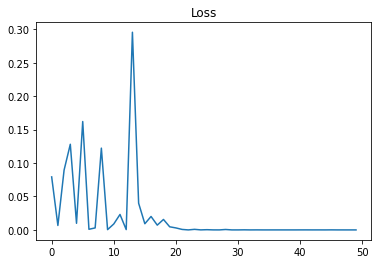

In [54]:
plt.plot(df_loss)
plt.title("Loss")

In [41]:
recall = {"Recall":[0.9363057613372803,0.9423897862434387,0.9599714279174805,0.9635193347930908,0.9839298725128174,0.9850533604621887,
                0.9893918037414551,0.9942113161087036,0.9935158491134644,0.9957112073898315,0.9985496997833252,0.9778096079826355,
                0.9950669407844543,0.9929726123809814,0.9860140085220337,0.9942979216575623,0.9985693693161011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,
                1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]}

In [42]:
df_re = pd.DataFrame(recall)

In [43]:
df_re

,Recall
0,0.936306
1,0.942390
2,0.959971
3,0.963519
4,0.983930
5,0.985053
6,0.989392
7,0.994211
8,0.993516
9,0.995711


Text(0.5, 1.0, 'Recall')

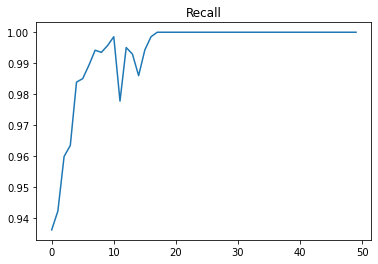

In [53]:
plt.plot(df_re)
plt.title("Recall")

In [48]:
pre = {"Precision":[0.9792746305465698, 0.9917664527893066, 0.9896831512451172,0.9926307797431946,0.9955654144287109,0.9935390949249268,
                   0.9971489906311035,0.9985465407371521,0.9956678748130798,0.9978510141372681,0.9992743134498596,0.9884225726127625,
                   1.0,0.9964739084243774,0.9839497804641724,0.9957173466682434,0.9992842078208923,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,
                   1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]}

In [49]:
df_pre = pd.DataFrame(pre)

In [50]:
df_pre

,Precision
0,0.979275
1,0.991766
2,0.989683
3,0.992631
4,0.995565
5,0.993539
6,0.997149
7,0.998547
8,0.995668
9,0.997851


Text(0.5, 1.0, 'Precision')

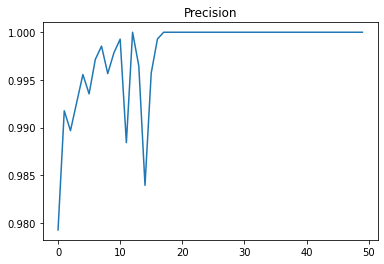

In [52]:
plt.plot(df_pre)
plt.title("Precision")

In [13]:
model = tf.keras.models.load_model("siamesemodelv3.h5", custom_objects={"L1Dist":L1Dist})

In [14]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

y_hat = model.predict([test_input, test_val])

[1 if prediction > 0.5 else 0 for prediction in y_hat]

1/1 [==============================] - 2s 2s/step


[0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0]

In [15]:
y_true

array([0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [16]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [17]:
m = Precision()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

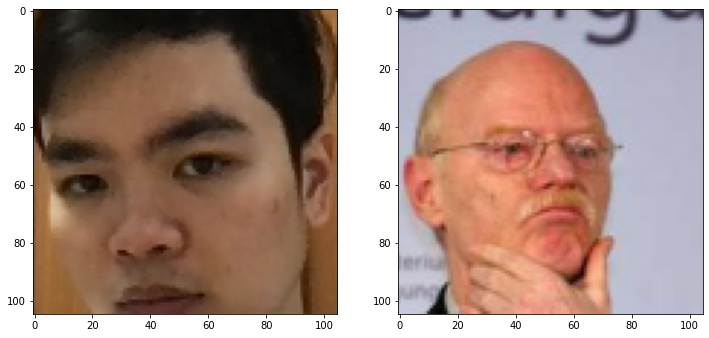

In [18]:
plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.imshow(test_input[-2])
plt.subplot(1, 2, 2)
plt.imshow(test_val[-2])
plt.show()

In [25]:
siamese_model.save("siamesemodelv3.h5")

In [61]:
model = tf.keras.models.load_model("siamesemodelv3.h5", custom_objects={"L1Dist":L1Dist})

In [20]:
model.summary()

Model: "siameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 val_image (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'val_image[0][0]'] 

In [14]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_preds = model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [15]:
[1 if prediction > 0.5 else 0 for prediction in y_preds]

[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

In [19]:
def verify(model, detection_threshold, verification_threshold):
    
    results = []
    for image in os.listdir(os.path.join("application_data", "verification_images")):
        input_img = preprocess(os.path.join("application_data", "input_image", "input_image.jpg"))
        validation_img = preprocess(os.path.join("application_data", "verification_images", image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis = 1)))
        results.append(result)
        
    detection = np.sum(np.array(results) > detection_threshold)
    verification = detection / len(os.listdir(os.path.join("application_data", "verification_images")))
    verified = verification > verification_threshold
    
    return results, verified

In [20]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    
    ret, frame = cap.read()
    frame = frame[200:200+250, 580:580+250, :]
    
    cv2.imshow("Verification:", frame)
    
    if cv2.waitKey(1) & 0xFF == ord("v"):
        cv2.imwrite(os.path.join("application_data", "input_image", "input_image.jpg"), frame)
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
        
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
    
cap.release()
cv2.DestroyAllWindows()

1/1 [==============================] - 0s 227ms/step
False
1/1 [==============================] - 0s 226ms/step
False


AttributeError: module 'cv2' has no attribute 'DestroyAllWindows'

In [32]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    
    ret, frame = cap.read()
    
    frame = frame[200:200+250, 580:580+250, :]
    
    cv2.imshow("Webcam:", frame)
    
        
    if cv2.waitKey(1) & 0XFF == ord("p"):
        imgname = os.path.join("application_data", "verification_images", "{}.jpeg".format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()